In [1]:
import os
import itertools
import matplotlib

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow.keras.backend as K

from tqdm import tqdm
from scipy.spatial import distance

In [2]:
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}

matplotlib.rc('font', **font)

In [3]:
np.random.seed(0)

https://arxiv.org/pdf/2103.03386.pdf

https://github.com/dfilan/clusterability_in_neural_networks

https://github.com/dfilan/clusterability_in_neural_networks/blob/72602084ea8d686a80fb7e7ec4d736846f83b27f/src/train_nn.py #L836 - training data


In [4]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

x_train = x_train / 255.
x_test = x_test / 255.

y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)

y_train = np.argmax(y_train, axis=1)

order = np.random.permutation(len(x_train))

x_train = x_train[order]
y_train = y_train[order]


y_train = tf.keras.utils.to_categorical(y_train, 10)

x_train_reshape = [x_train[i].reshape((784)) for i in range(len(x_train))]
print(np.array(x_train_reshape).shape)

x_test_reshape = [x_test[i].reshape((784)) for i in range(len(x_test))]
print(np.array(x_test_reshape).shape)

(60000, 784)
(10000, 784)


In [5]:
n_hidden_neurons = 256
lr = 0.001
epochs = 100 # clusterability paper uses 40 epochs. 20 training, 20 training with pruning
batch_size = 128
limit = (batch_size * (len(x_train) // batch_size)) # number of training examples to use. Must be multiple of batch_size
test_limit = (batch_size * (len(x_test) // batch_size)) # Must be multiple of batch_size
alpha = 1.0 # penalise polysemantic neurons.

In [6]:
i = tf.keras.layers.Input(shape=(28*28,))
i2 = tf.keras.layers.Input(shape=(10,))
e1 = tf.keras.layers.Dense(n_hidden_neurons, activation='relu', name='dense_1')(i)
e2 = tf.keras.layers.Dense(n_hidden_neurons, activation='relu', name='dense_2')(e1)
e3 = tf.keras.layers.Dense(n_hidden_neurons, activation='relu', name='dense_3')(e2)
e4 = tf.keras.layers.Dense(n_hidden_neurons, activation='relu', name='dense_4')(e3)
o = tf.keras.layers.Dense(10, activation='softmax', name='softmax')(e4)
model = tf.keras.Model(inputs=[i, i2], outputs=o)

2022-06-07 21:25:06.243114: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2022-06-07 21:25:06.257638: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f83170b7570 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2022-06-07 21:25:06.257667: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version


### define polysemantic loss

In [7]:
# def calculate_term(e, c0, c1):
#     a = tf.gather(indices=c0, params=e) \
#       / tf.tile(K.expand_dims(K.max(K.abs(tf.gather(indices=c0, params=e)), axis=1) + 1e-9), (1, e.shape[-1]))
#     b = tf.gather(indices=c1, params=e) \
#       / tf.tile(K.expand_dims(K.max(K.abs(tf.gather(indices=c1, params=e)), axis=1) + 1e-9), (1, e.shape[-1]))
#     return K.sum(a*b, axis=1)

In [8]:
def calculate_term(e, c0, c1):
    a = tf.cast(tf.gather(indices=c0, params=e) > 0., dtype='float32')
    b = tf.cast(tf.gather(indices=c1, params=e) > 0., dtype='float32')
    return K.sum(a*b, axis=1)

In [9]:
def my_loss(y_true, y_pred, e1, e2, e3, e4, c0, c1, alpha):
    
    p_loss = K.sum((1. - (tf.cast(tf.equal(K.argmax(tf.gather(indices=c0, params=y_true)), 
                                     K.argmax(tf.gather(indices=c1, params=y_true))), dtype='float32'))) \
           * calculate_term(e1, c0, c1))
    
    p_loss += K.sum((1. - (tf.cast(tf.equal(K.argmax(tf.gather(indices=c0, params=y_true)), 
                                     K.argmax(tf.gather(indices=c1, params=y_true))), dtype='float32'))) \
           * calculate_term(e2, c0, c1))
    
    p_loss += K.sum((1. - (tf.cast(tf.equal(K.argmax(tf.gather(indices=c0, params=y_true)), 
                                     K.argmax(tf.gather(indices=c1, params=y_true))), dtype='float32'))) \
           * calculate_term(e3, c0, c1))
    
    p_loss += K.sum((1. - (tf.cast(tf.equal(K.argmax(tf.gather(indices=c0, params=y_true)), 
                                     K.argmax(tf.gather(indices=c1, params=y_true))), dtype='float32'))) \
           * calculate_term(e4, c0, c1))
    
    loss = tf.keras.losses.CategoricalCrossentropy(from_logits=False)(y_true=y_true, 
                                                                      y_pred=y_pred)
    loss += alpha * (p_loss / len(c0))

    return loss

### precalculate all indices for batch_size choose 2 pairs

In [10]:
c0, c1 = [], []
for c in list(itertools.combinations(range(batch_size), 2)):
    c0.append(c[0])
    c1.append(c[1])

In [11]:
print(len(c0))

8128


In [12]:
model.add_loss(my_loss(i2, o, e1, e2, e3, e4, np.array(c0, dtype='int32'), np.array(c1, dtype='int32'), alpha))

In [13]:
def my_acc(y_true, y_pred):
    y_pred = tf.cast(tf.math.greater(y_pred, tf.constant([0.5])), dtype='float32')
    return tf.cast(tf.math.equal(y_true, y_pred), dtype='float32')

def cce(y_true, y_pred):
    return tf.keras.losses.CategoricalCrossentropy(
        from_logits=False,
        reduction=tf.keras.losses.Reduction.NONE
    )(y_true=y_true, y_pred=y_pred)

def ps_term(y_true, e, c0, c1):
    p_loss = (1. - (tf.cast(tf.equal(K.argmax(tf.gather(indices=c0, params=y_true)), 
                                     K.argmax(tf.gather(indices=c1, params=y_true))), dtype='float32'))) \
           * calculate_term(e, c0, c1)
    return tf.convert_to_tensor(p_loss)
    
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), 
              loss=None)

model.add_metric(my_acc(i2, o), name='acc', aggregation='mean')
model.add_metric(cce(i2, o), name='cce', aggregation='mean')
model.add_metric(my_loss(i2, o, e1, e2, e3, e4, c0, c1, alpha), name='p_loss', aggregation='mean') 
model.add_metric(ps_term(i2, e1, c0, c1), name='ps1', aggregation='mean')
model.add_metric(ps_term(i2, e2, c0, c1), name='ps2', aggregation='mean')
model.add_metric(ps_term(i2, e3, c0, c1), name='ps3', aggregation='mean')
model.add_metric(ps_term(i2, e4, c0, c1), name='ps4', aggregation='mean')

In [14]:
history = model.fit([np.array(x_train_reshape)[:limit], y_train[:limit]],
                    y=None,
                    validation_data=([np.array(x_test_reshape)[:test_limit], 
                                     y_test[:test_limit]], None),
                    batch_size=batch_size,
                    epochs=epochs)

Train on 59904 samples, validate on 9984 samples
Epoch 1/100
59904/59904 [==============================] - 17s 290us/sample - loss: 367.1558 - acc: 0.9855 - cce: 0.2517 - p_loss: 367.1556 - ps1: 79.8920 - ps2: 88.9985 - ps3: 99.4071 - ps4: 98.6065 - val_loss: 292.5285 - val_acc: 0.9932 - val_cce: 0.1157 - val_p_loss: 292.5285 - val_ps1: 57.5415 - val_ps2: 70.8446 - val_ps3: 80.1916 - val_ps4: 83.8351
Epoch 2/100
59904/59904 [==============================] - 15s 258us/sample - loss: 263.3297 - acc: 0.9943 - cce: 0.0964 - p_loss: 263.3297 - ps1: 48.1818 - ps2: 61.5963 - ps3: 73.3383 - ps4: 80.1170 - val_loss: 229.7885 - val_acc: 0.9947 - val_cce: 0.0888 - val_p_loss: 229.7886 - val_ps1: 40.1857 - val_ps2: 53.2322 - val_ps3: 64.5273 - val_ps4: 71.7545
Epoch 3/100
59904/59904 [==============================] - 15s 252us/sample - loss: 221.4860 - acc: 0.9959 - cce: 0.0659 - p_loss: 221.4860 - ps1: 37.7569 - ps2: 50.1623 - ps3: 62.1860 - ps4: 71.3149 - val_loss: 193.0010 - val_acc: 0.9954 

Epoch 24/100
59904/59904 [==============================] - 15s 253us/sample - loss: 55.0090 - acc: 0.9994 - cce: 0.0102 - p_loss: 55.0091 - ps1: 13.7463 - ps2: 13.2768 - ps3: 9.4366 - ps4: 18.5393 - val_loss: 53.1478 - val_acc: 0.9966 - val_cce: 0.0967 - val_p_loss: 53.1478 - val_ps1: 13.4006 - val_ps2: 13.3655 - val_ps3: 8.8348 - val_ps4: 17.4502
Epoch 25/100
59904/59904 [==============================] - 15s 253us/sample - loss: 52.3875 - acc: 0.9994 - cce: 0.0108 - p_loss: 52.3876 - ps1: 13.0889 - ps2: 13.1606 - ps3: 8.8366 - ps4: 17.2906 - val_loss: 51.3663 - val_acc: 0.9964 - val_cce: 0.0934 - val_p_loss: 51.3663 - val_ps1: 13.0019 - val_ps2: 12.5813 - val_ps3: 8.5735 - val_ps4: 17.1163
Epoch 26/100
59904/59904 [==============================] - 15s 252us/sample - loss: 51.1173 - acc: 0.9995 - cce: 0.0089 - p_loss: 51.1173 - ps1: 12.9624 - ps2: 12.5042 - ps3: 8.2919 - ps4: 17.3498 - val_loss: 50.8791 - val_acc: 0.9964 - val_cce: 0.1010 - val_p_loss: 50.8791 - val_ps1: 12.6843 - v

59904/59904 [==============================] - 15s 255us/sample - loss: 37.0457 - acc: 0.9999 - cce: 0.0032 - p_loss: 37.0457 - ps1: 12.0018 - ps2: 9.0121 - ps3: 4.4626 - ps4: 11.5660 - val_loss: 39.1418 - val_acc: 0.9948 - val_cce: 0.1883 - val_p_loss: 39.1418 - val_ps1: 12.8403 - val_ps2: 9.7421 - val_ps3: 4.8179 - val_ps4: 11.5532
Epoch 48/100
59904/59904 [==============================] - 15s 257us/sample - loss: 36.0222 - acc: 0.9996 - cce: 0.0084 - p_loss: 36.0222 - ps1: 12.1776 - ps2: 9.1085 - ps3: 4.4044 - ps4: 10.3233 - val_loss: 35.9453 - val_acc: 0.9963 - val_cce: 0.1164 - val_p_loss: 35.9453 - val_ps1: 12.2493 - val_ps2: 8.6886 - val_ps3: 4.5542 - val_ps4: 10.3369
Epoch 49/100
59904/59904 [==============================] - 15s 252us/sample - loss: 35.7714 - acc: 0.9998 - cce: 0.0036 - p_loss: 35.7714 - ps1: 11.9562 - ps2: 8.6056 - ps3: 4.4850 - ps4: 10.7210 - val_loss: 37.1954 - val_acc: 0.9962 - val_cce: 0.1188 - val_p_loss: 37.1954 - val_ps1: 13.0789 - val_ps2: 9.2690 - v

Epoch 71/100
59904/59904 [==============================] - 15s 253us/sample - loss: 29.9800 - acc: 0.9998 - cce: 0.0041 - p_loss: 29.9800 - ps1: 10.9987 - ps2: 7.8633 - ps3: 3.8392 - ps4: 7.2746 - val_loss: 30.5640 - val_acc: 0.9969 - val_cce: 0.1287 - val_p_loss: 30.5640 - val_ps1: 11.2497 - val_ps2: 7.9466 - val_ps3: 3.9490 - val_ps4: 7.2900
Epoch 72/100
59904/59904 [==============================] - 15s 255us/sample - loss: 31.0668 - acc: 1.0000 - cce: 1.5813e-04 - p_loss: 31.0668 - ps1: 10.7732 - ps2: 7.7778 - ps3: 4.3858 - ps4: 8.1299 - val_loss: 32.8971 - val_acc: 0.9969 - val_cce: 0.1427 - val_p_loss: 32.8971 - val_ps1: 10.8601 - val_ps2: 7.9579 - val_ps3: 4.8391 - val_ps4: 9.0974
Epoch 73/100
59904/59904 [==============================] - 15s 254us/sample - loss: 32.5331 - acc: 1.0000 - cce: 2.5509e-06 - p_loss: 32.5331 - ps1: 10.6245 - ps2: 7.7769 - ps3: 4.7666 - ps4: 9.3651 - val_loss: 33.3214 - val_acc: 0.9969 - val_cce: 0.1458 - val_p_loss: 33.3214 - val_ps1: 10.8869 - val

59904/59904 [==============================] - 16s 273us/sample - loss: 36.6010 - acc: 1.0000 - cce: 1.2267e-07 - p_loss: 36.6010 - ps1: 10.6809 - ps2: 7.8278 - ps3: 4.8211 - ps4: 13.2712 - val_loss: 37.5203 - val_acc: 0.9969 - val_cce: 0.1694 - val_p_loss: 37.5203 - val_ps1: 10.9282 - val_ps2: 8.0049 - val_ps3: 4.9019 - val_ps4: 13.5159
Epoch 95/100
59904/59904 [==============================] - 16s 264us/sample - loss: 36.7108 - acc: 1.0000 - cce: 1.2191e-07 - p_loss: 36.7108 - ps1: 10.6789 - ps2: 7.8282 - ps3: 4.8236 - ps4: 13.3801 - val_loss: 37.6501 - val_acc: 0.9969 - val_cce: 0.1700 - val_p_loss: 37.6501 - val_ps1: 10.9296 - val_ps2: 8.0070 - val_ps3: 4.9040 - val_ps4: 13.6396
Epoch 96/100
59904/59904 [==============================] - 16s 261us/sample - loss: 36.8296 - acc: 1.0000 - cce: 1.2133e-07 - p_loss: 36.8296 - ps1: 10.6803 - ps2: 7.8309 - ps3: 4.8250 - ps4: 13.4934 - val_loss: 37.7717 - val_acc: 0.9969 - val_cce: 0.1705 - val_p_loss: 37.7717 - val_ps1: 10.9305 - val_ps2

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


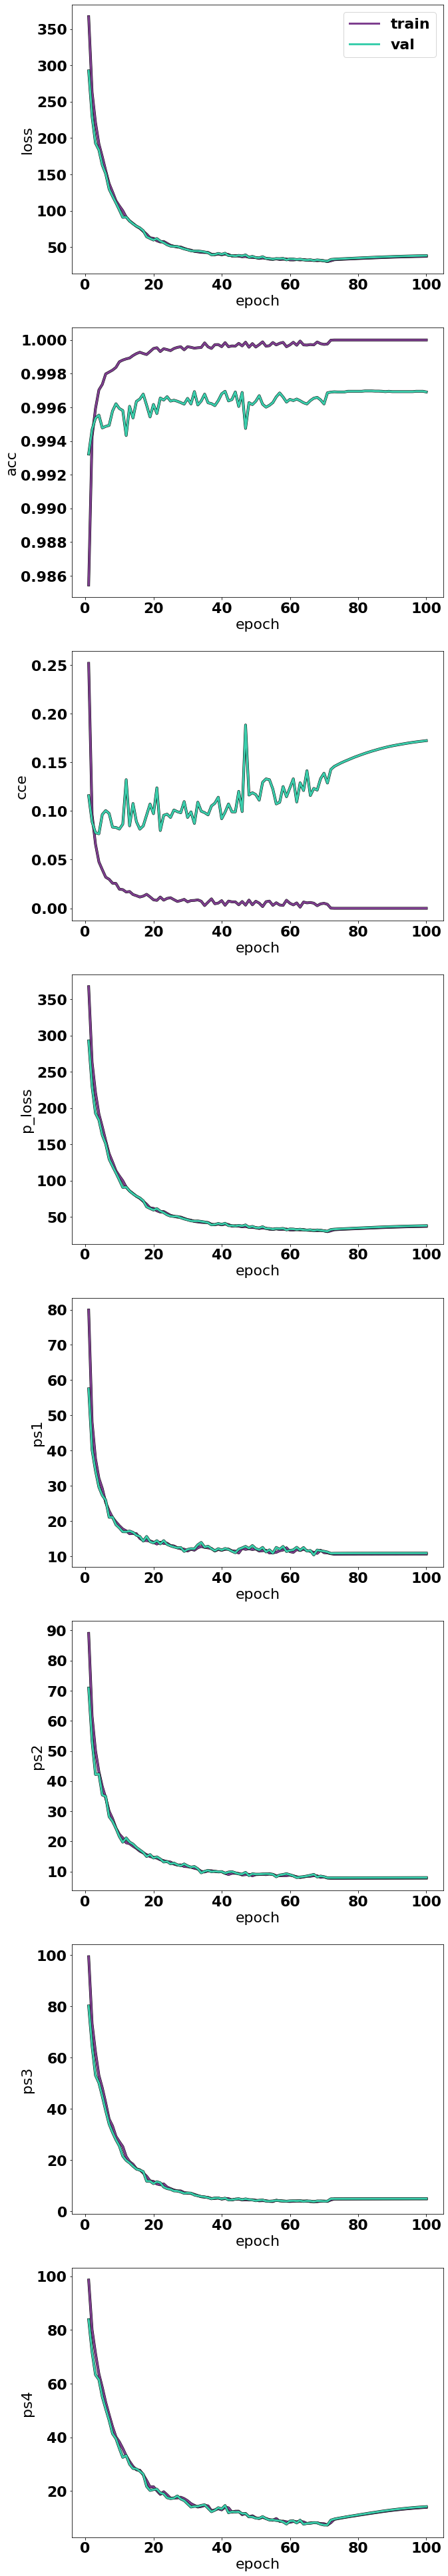

In [15]:
fig = plt.figure(figsize=(10,70))
for j,m in enumerate(['loss', 'acc', 'cce', 'p_loss', 'ps1', 'ps2', 'ps3', 'ps4']):
    ax = fig.add_subplot(8,1,j+1)
    ax.plot(range(1,epochs+1), np.squeeze(history.history[m]), 'k-', lw=4)
    t, = ax.plot(range(1,epochs+1), np.squeeze(history.history[m]), '-', color='#7E3F8F', lw=3)
    ax.plot(range(1,epochs+1), np.squeeze(history.history['val_{}'.format(m)]), 'k-', lw=4)
    v, = ax.plot(range(1,epochs+1), np.squeeze(history.history['val_{}'.format(m)]), '-', color='#3BCEAC', lw=3)
    ax.set_ylabel(m)
    ax.set_xlabel('epoch')
    if j == 0:
        ax.legend([t, v], ['train', 'val'])
    #ax.set_yscale('log')

### calculate test set accuracy

In [16]:
inference = tf.keras.Model(inputs=i, outputs=o)
y_pred_test = inference.predict(np.array(x_test_reshape))
print(np.mean(my_acc(y_test, y_pred_test)))

0.99692


### calculate activations across the training set

In [17]:
def plot_activations(embed, x, y):
    activations_by_class = {}
    a = embed.predict(x)
    for j in tqdm(range(len(x))):
        try:
            activations_by_class[y[j]] += np.squeeze(a[j])
        except KeyError:
            activations_by_class[y[j]] = np.squeeze(a[j])
    fig = plt.figure(figsize=(20,20))
    classes = list(activations_by_class.keys())
    classes.sort()
    for i,k in enumerate(classes):
        y_pos = np.arange(len(activations_by_class[k]))
        ax = fig.add_subplot(2, 5, i+1)
        ax.set_title(k)
        ax.barh(y_pos, np.log(np.squeeze(activations_by_class[k])), align='center')
        ax.plot([0,0],[-1,len(np.squeeze(activations_by_class[k]))], 'k-')
        ax.set_ylim(-1,len(np.squeeze(activations_by_class[k])))
        fig.text(0.5, 0.04, 'log summed activation', ha='center')
        fig.text(0.04, 0.5, 'neuron index', va='center', rotation='vertical')
    sum = 0
    for c in list(itertools.combinations(range(10), 2)):
        a = (np.squeeze(activations_by_class[c[0]]) / (np.max(np.abs(np.squeeze(activations_by_class[c[0]])))) + 1e-9)
        b = (np.squeeze(activations_by_class[c[1]]) / (np.max(np.abs(np.squeeze(activations_by_class[c[1]])))) + 1e-9)
        sum += np.dot(np.transpose(a), b)
    print(sum/len(list(itertools.combinations(range(10), 2))))
    return activations_by_class, (sum/len(list(itertools.combinations(range(10), 2))))

In [18]:
train_ps_metrics = []

In [19]:
embed1 = tf.keras.Model(inputs=i, outputs=e1)

embed1.layers[1].set_weights(model.layers[1].get_weights())

100%|█████████████████████████████████████████████████████████████████████████████| 59904/59904 [00:00<00:00, 335762.24it/s]
/Users/dwright/anaconda2/envs/polysemantic_neurons/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in log
  app.launch_new_instance()
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


3.4722162008285524


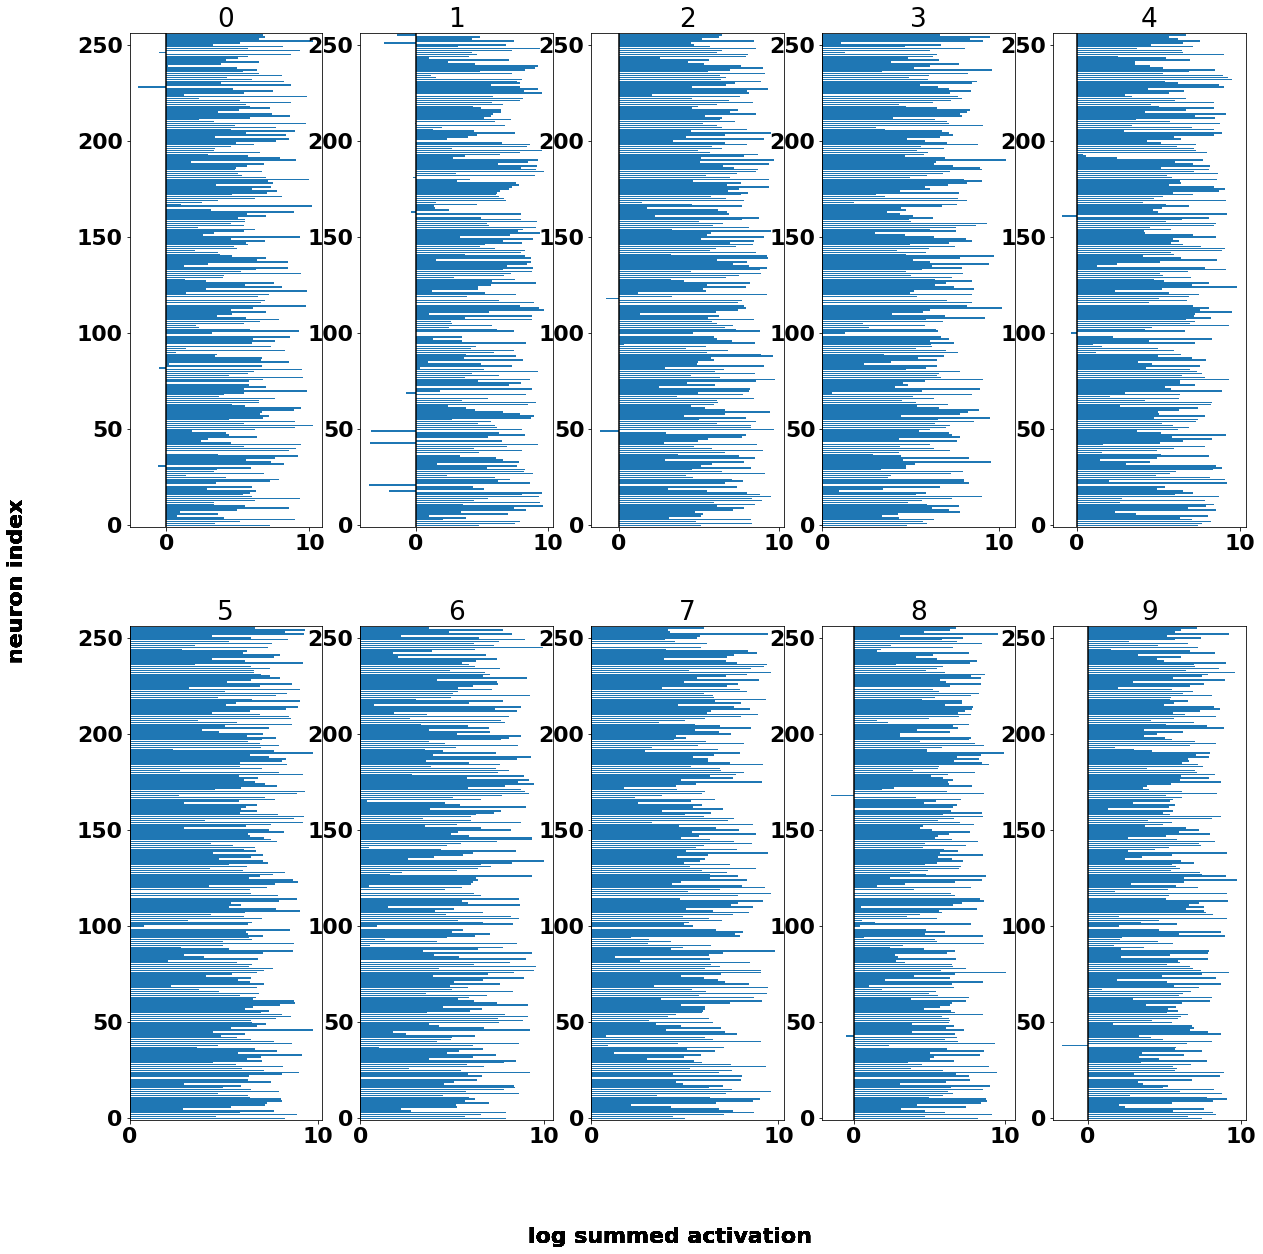

In [20]:
embed1_activations_by_class, ps_metric = plot_activations(embed1, 
                                                          np.array(x_train_reshape)[:limit], 
                                                          np.argmax(y_train, axis=1)[:limit])
train_ps_metrics.append(ps_metric)

In [21]:
embed2_input = tf.keras.layers.Input(shape=(28*28,))
embed2_hidden1 = tf.keras.layers.Dense(n_hidden_neurons, activation='relu', name='embed2_hidden1')(embed2_input)
embed2_output = tf.keras.layers.Dense(n_hidden_neurons, activation='relu', name='embed2_output')(embed2_hidden1)
embed2 = tf.keras.Model(inputs=embed2_input, outputs=embed2_output)

embed2.layers[1].set_weights(model.layers[1].get_weights())
embed2.layers[2].set_weights(model.layers[2].get_weights())

100%|█████████████████████████████████████████████████████████████████████████████| 59904/59904 [00:00<00:00, 323338.38it/s]
/Users/dwright/anaconda2/envs/polysemantic_neurons/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in log
  app.launch_new_instance()


1.5381306297249264


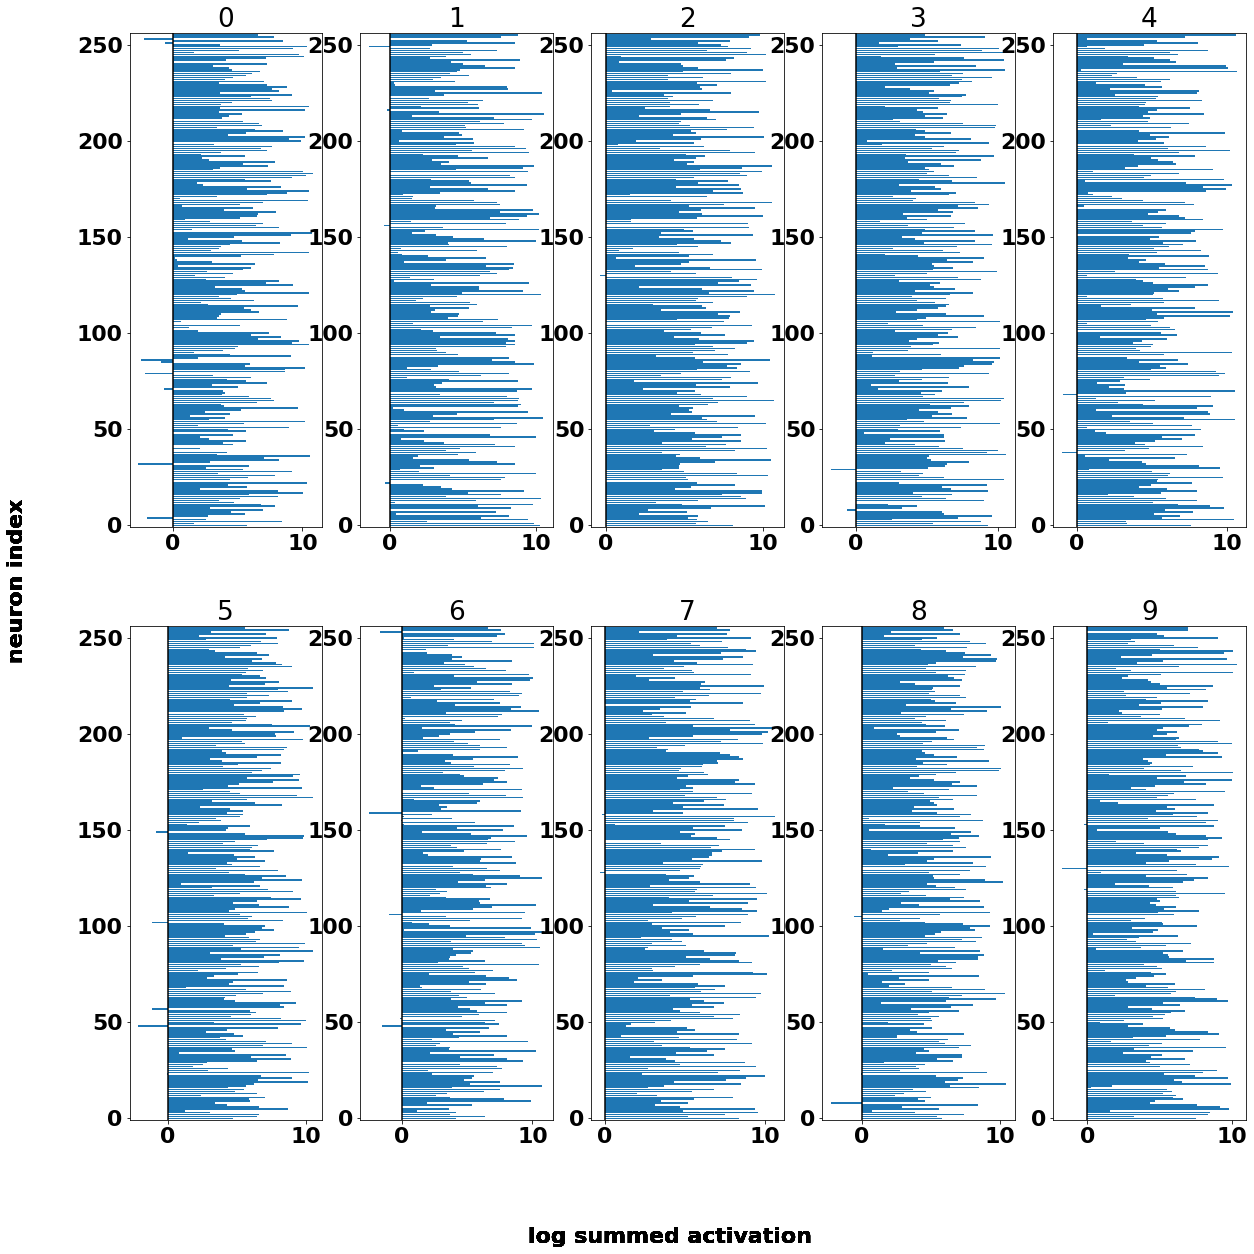

In [22]:
embed2_activations_by_class, ps_metric = plot_activations(embed2, 
                                                          np.array(x_train_reshape)[:limit], 
                                                          np.argmax(y_train, axis=1)[:limit])
train_ps_metrics.append(ps_metric)

In [23]:
embed3_input = tf.keras.layers.Input(shape=(28*28,))
embed3_hidden1 = tf.keras.layers.Dense(n_hidden_neurons, activation='relu', name='embed3_hidden1')(embed3_input)
embed3_hidden2 = tf.keras.layers.Dense(n_hidden_neurons, activation='relu', name='embed3_hidden2')(embed3_hidden1)
embed3_output = tf.keras.layers.Dense(n_hidden_neurons, activation='relu', name='embed3_output')(embed3_hidden2)
embed3 = tf.keras.Model(inputs=embed3_input, outputs=embed3_output)

embed3.layers[1].set_weights(model.layers[1].get_weights())
embed3.layers[2].set_weights(model.layers[2].get_weights())
embed3.layers[3].set_weights(model.layers[3].get_weights())

100%|█████████████████████████████████████████████████████████████████████████████| 59904/59904 [00:00<00:00, 303531.26it/s]
/Users/dwright/anaconda2/envs/polysemantic_neurons/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in log
  app.launch_new_instance()


1.3268552819887798


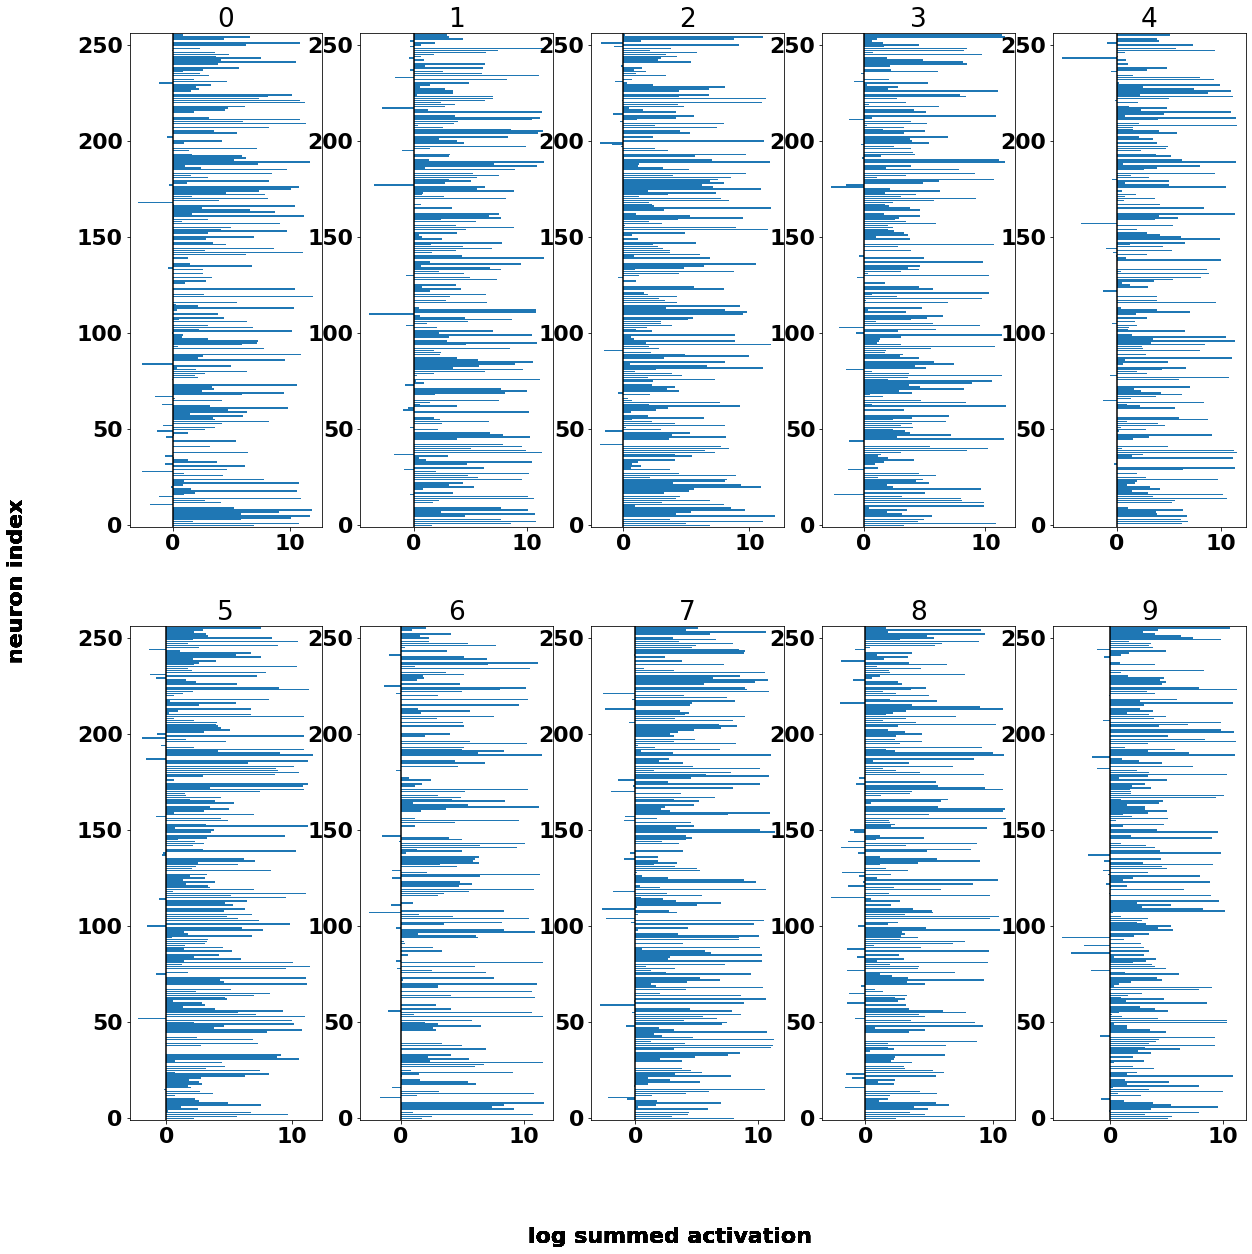

In [24]:
embed3_activations_by_class, ps_metric = plot_activations(embed3, 
                                                          np.array(x_train_reshape)[:limit], 
                                                          np.argmax(y_train, axis=1)[:limit])
train_ps_metrics.append(ps_metric)

In [25]:
embed4_input = tf.keras.layers.Input(shape=(28*28,))
embed4_hidden1 = tf.keras.layers.Dense(n_hidden_neurons, activation='relu', name='embed4_hidden1')(embed4_input)
embed4_hidden2 = tf.keras.layers.Dense(n_hidden_neurons, activation='relu', name='embed4_hidden2')(embed4_hidden1)
embed4_hidden3 = tf.keras.layers.Dense(n_hidden_neurons, activation='relu', name='embed4_hidden3')(embed4_hidden2)
embed4_output = tf.keras.layers.Dense(n_hidden_neurons, activation='relu', name='embed4_output')(embed4_hidden3)
embed4 = tf.keras.Model(inputs=embed4_input, outputs=embed4_output)

embed4.layers[1].set_weights(model.layers[1].get_weights())
embed4.layers[2].set_weights(model.layers[2].get_weights())
embed4.layers[3].set_weights(model.layers[3].get_weights())
embed4.layers[4].set_weights(model.layers[4].get_weights())

100%|█████████████████████████████████████████████████████████████████████████████| 59904/59904 [00:00<00:00, 295957.97it/s]
/Users/dwright/anaconda2/envs/polysemantic_neurons/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in log
  app.launch_new_instance()


2.253012765778436


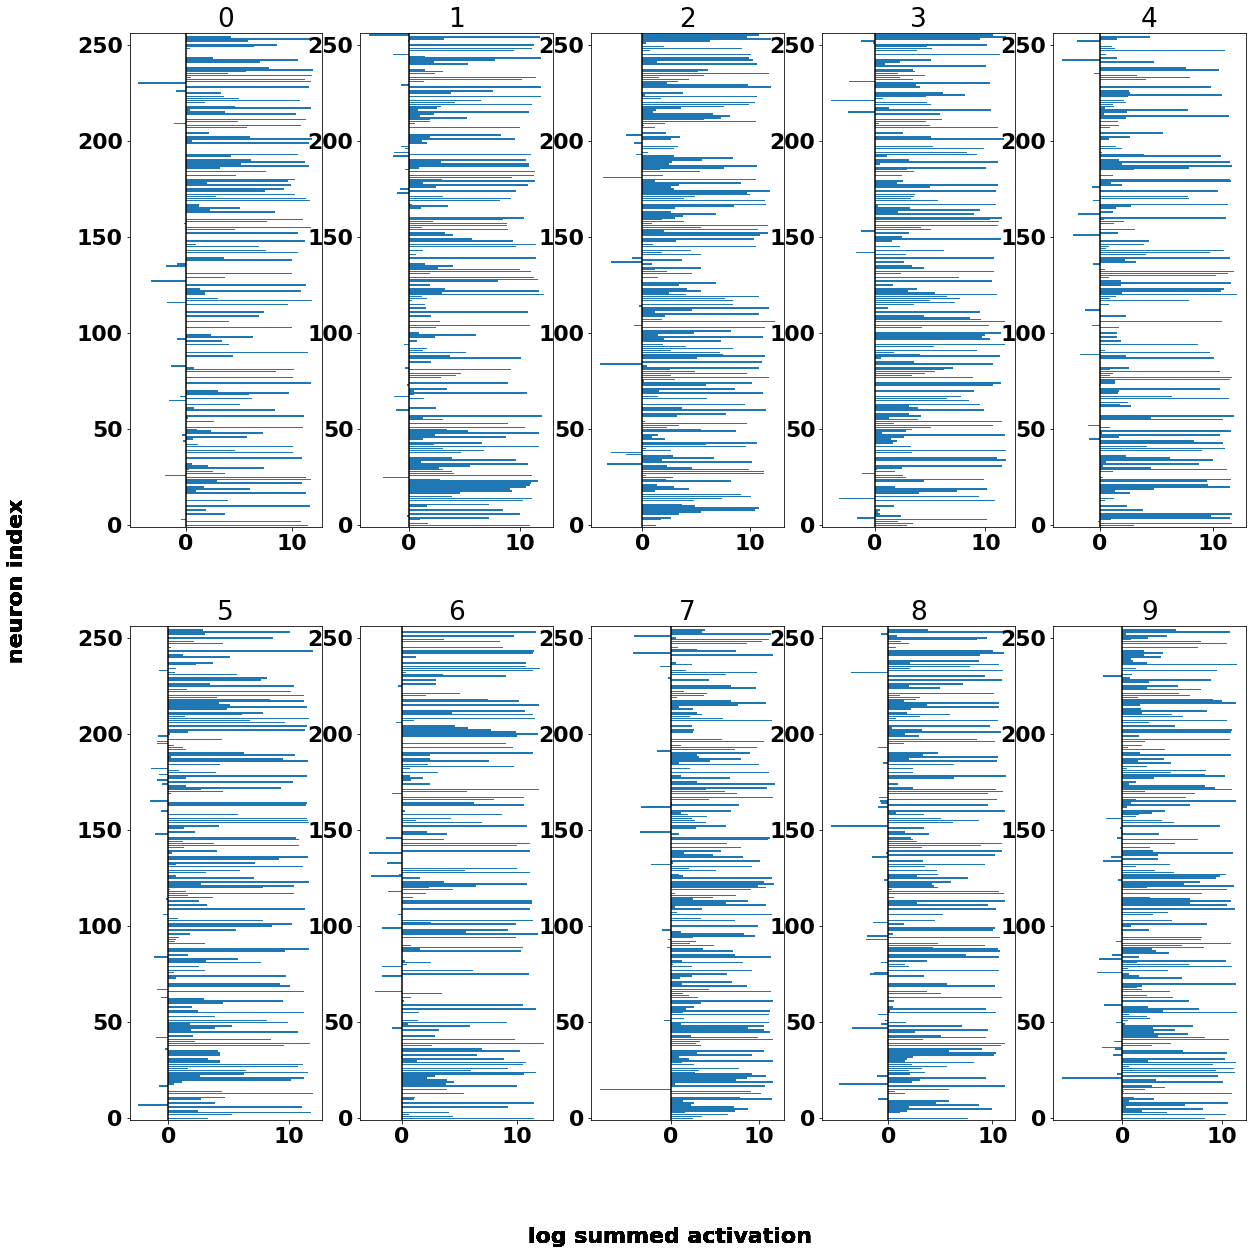

In [26]:
embed4_activations_by_class, ps_metric = plot_activations(embed4, 
                                                          np.array(x_train_reshape)[:limit], 
                                                          np.argmax(y_train, axis=1)[:limit])
train_ps_metrics.append(ps_metric)

In [27]:
np.mean(train_ps_metrics)

2.1475537195801735

### calculate activations across the test set

In [28]:
test_ps_metrics = []

100%|█████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 299479.77it/s]
/Users/dwright/anaconda2/envs/polysemantic_neurons/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in log
  app.launch_new_instance()


3.3531854152679443


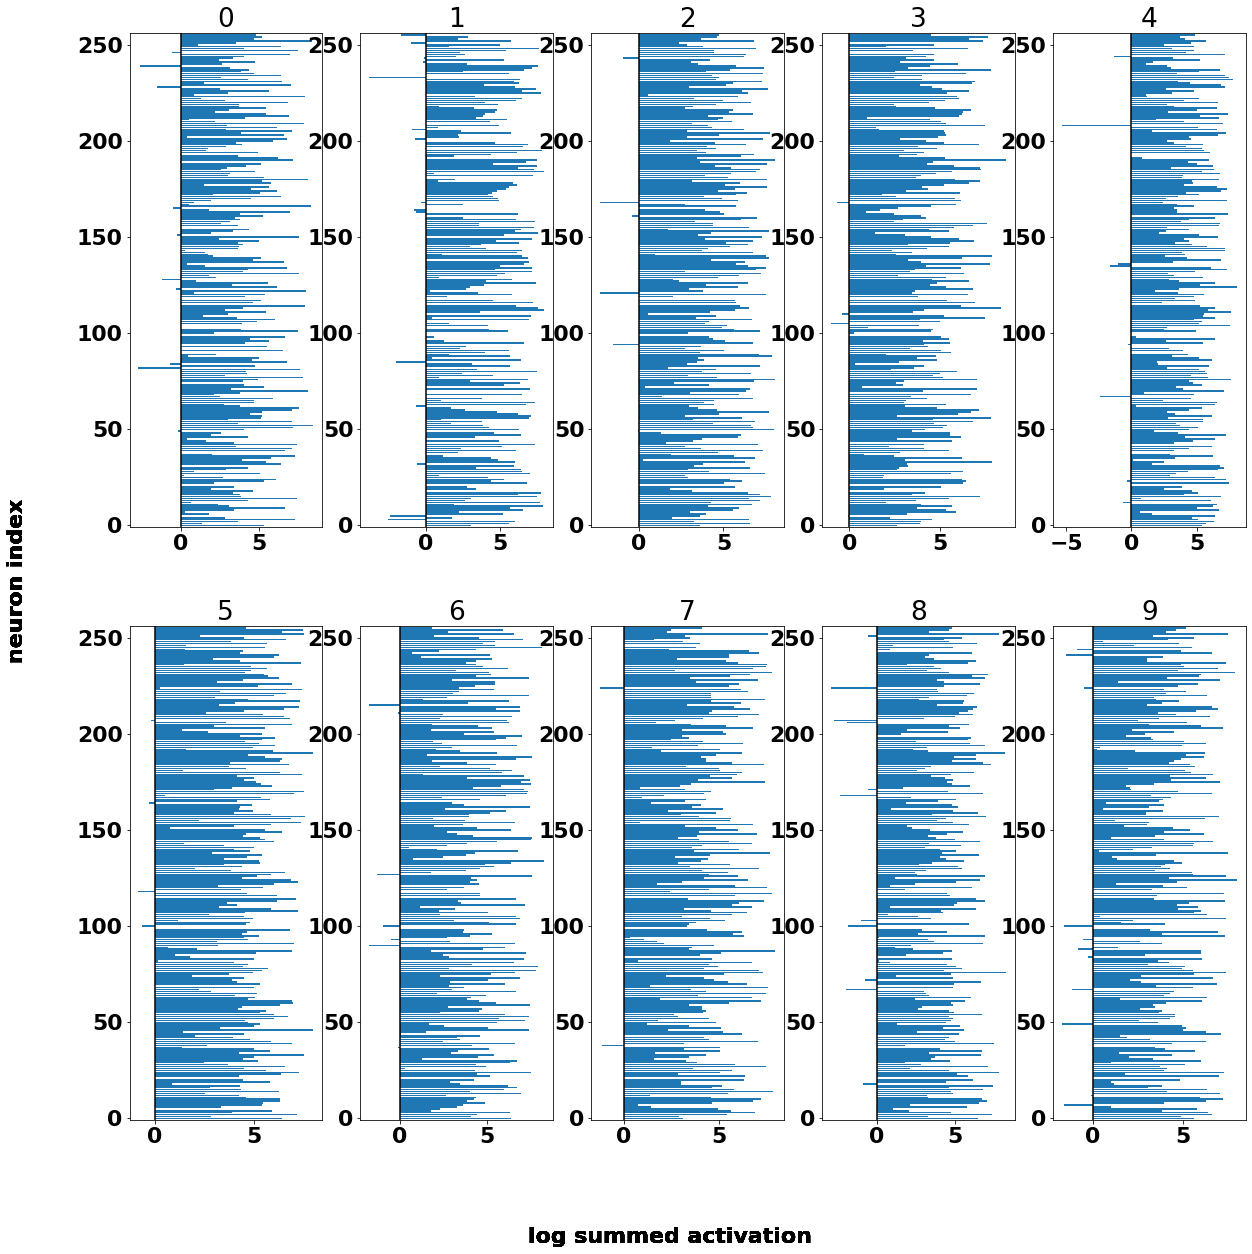

In [29]:
embed1_activations_by_class_test, ps_metric = plot_activations(embed1, 
                                                               np.array(x_test_reshape)[:limit], 
                                                               np.argmax(y_test, axis=1))
test_ps_metrics.append(ps_metric)

100%|█████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 308175.84it/s]
/Users/dwright/anaconda2/envs/polysemantic_neurons/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in log
  app.launch_new_instance()


1.5064175804456075


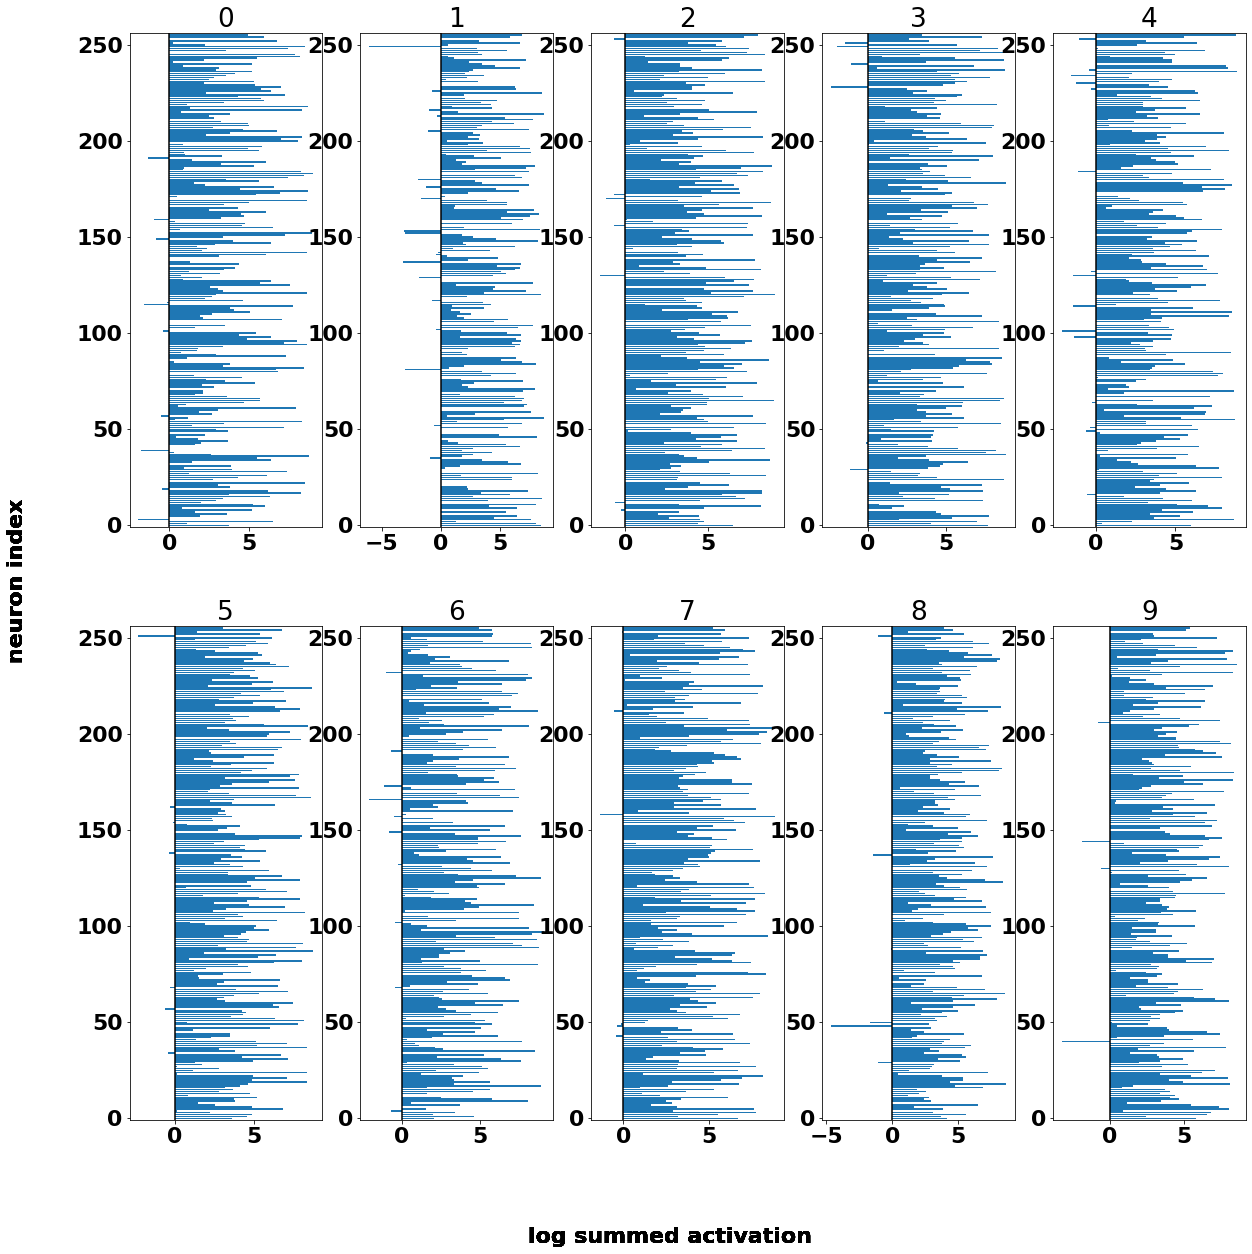

In [30]:
embed2_activations_by_class_test, ps_metric = plot_activations(embed2, 
                                                               np.array(x_test_reshape)[:limit], 
                                                               np.argmax(y_test, axis=1))
test_ps_metrics.append(ps_metric)

100%|█████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 297671.04it/s]
/Users/dwright/anaconda2/envs/polysemantic_neurons/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in log
  app.launch_new_instance()


1.3451483262909782


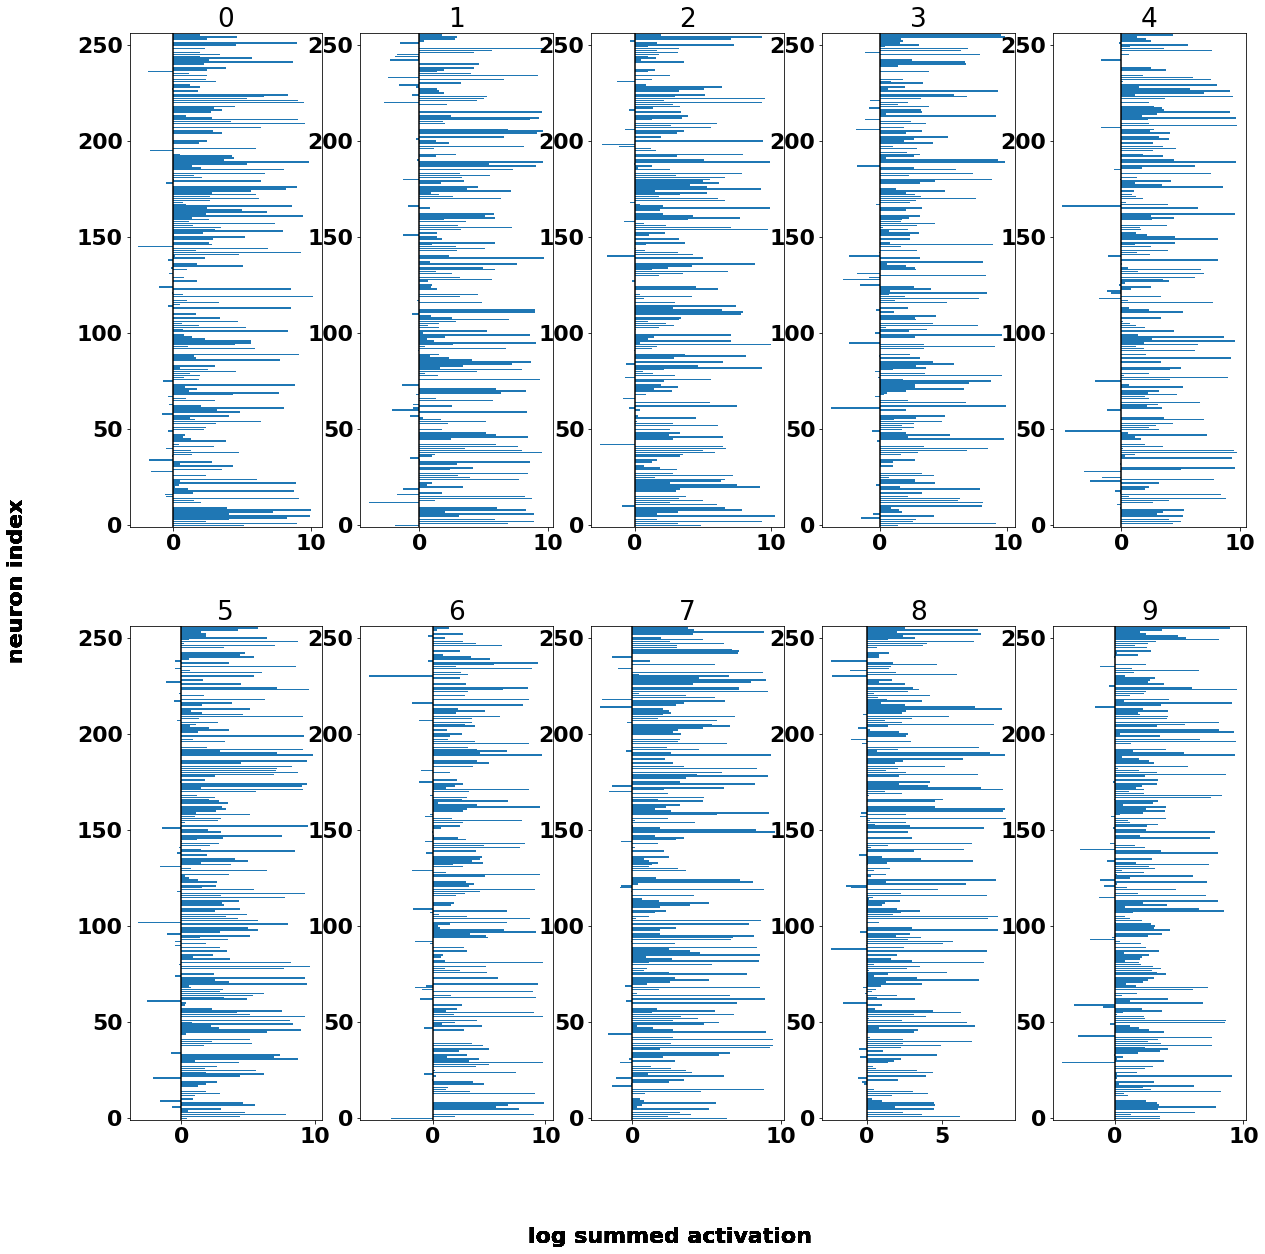

In [31]:
embed3_activations_by_class_test, ps_metric = plot_activations(embed3, 
                                                               np.array(x_test_reshape)[:limit], 
                                                               np.argmax(y_test, axis=1))
test_ps_metrics.append(ps_metric)

100%|█████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 297618.23it/s]
/Users/dwright/anaconda2/envs/polysemantic_neurons/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in log
  app.launch_new_instance()


2.271182522508833


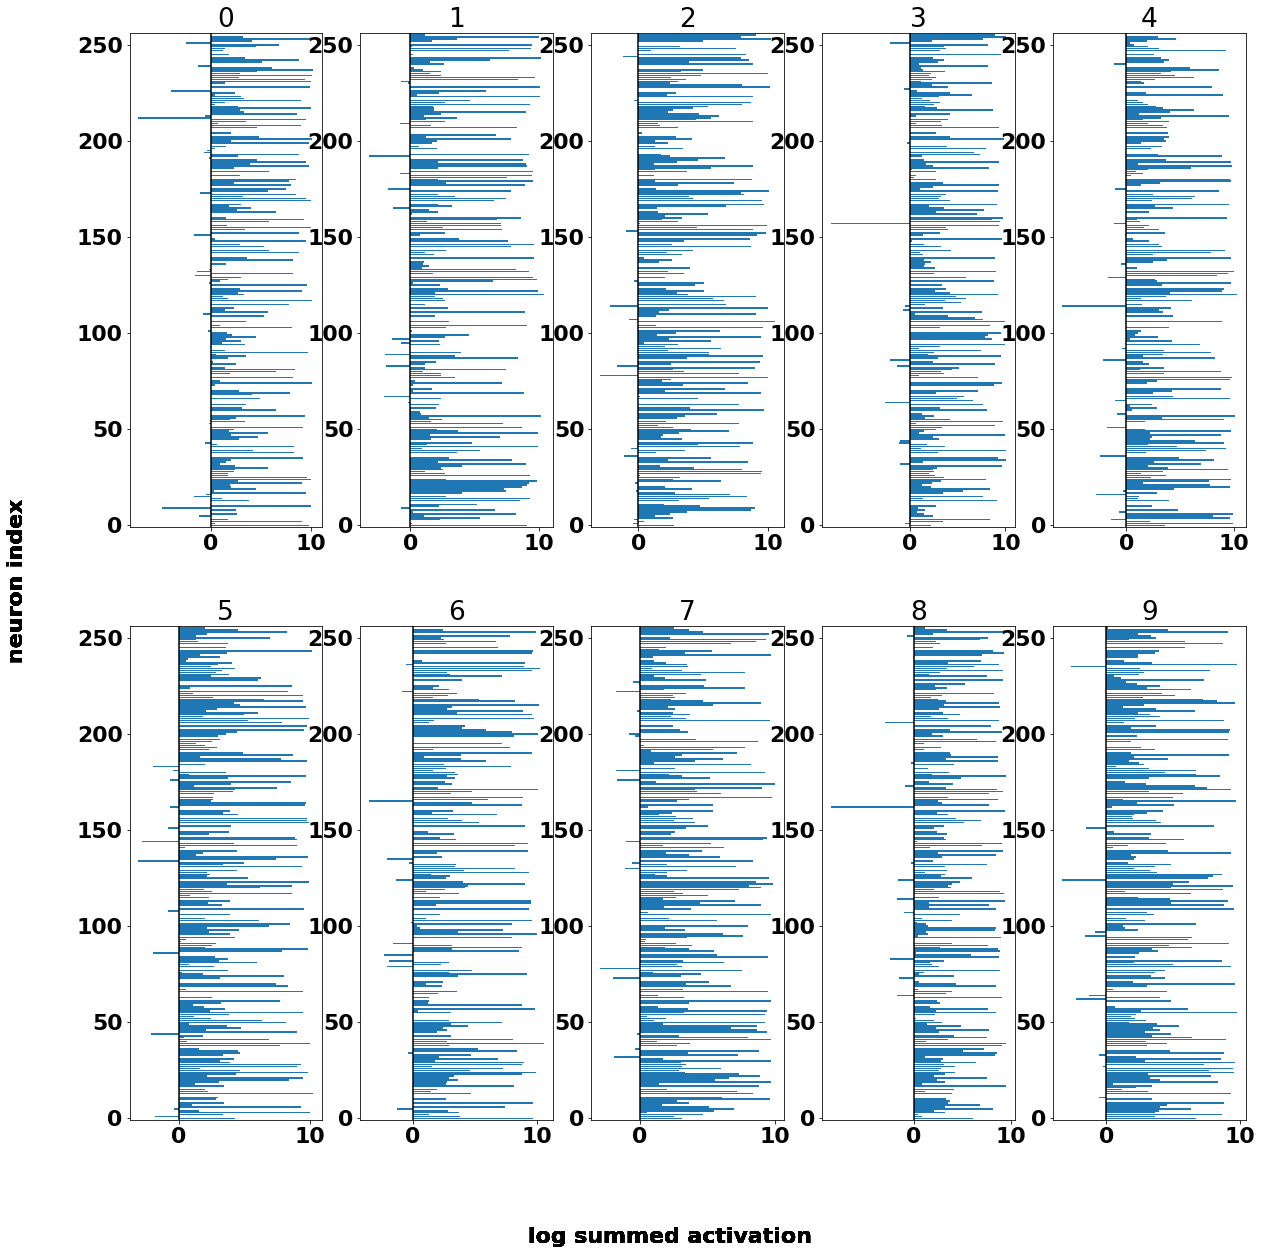

In [32]:
embed4_activations_by_class_test, ps_metric = plot_activations(embed4, 
                                                               np.array(x_test_reshape)[:limit], 
                                                               np.argmax(y_test, axis=1))
test_ps_metrics.append(ps_metric)

In [33]:
np.mean(test_ps_metrics)

2.118983461128341

### visualise hidden neurons

In [34]:
# TODO: for layers deeper than the first hidden layer the neurons could be 
# visualised as a weighted sum of the first layer activations
def visualise_hidden_neurons(model, layer_index, n_hidden_neurons, vis_shape):
    W = model.layers[layer_index].get_weights()
    fig = plt.figure(figsize=(20,20))
    dim = int(np.ceil(np.sqrt(n_hidden_neurons)))
    for j in range(n_hidden_neurons):
        x_j = W[0][:,j] / np.sqrt(np.sum(np.dot(W[0][:,j], W[0][:,j].T)))
        ax = fig.add_subplot(dim,dim,j+1)
        ax.imshow(x_j.reshape(vis_shape))
        plt.axis('off')
    plt.show()

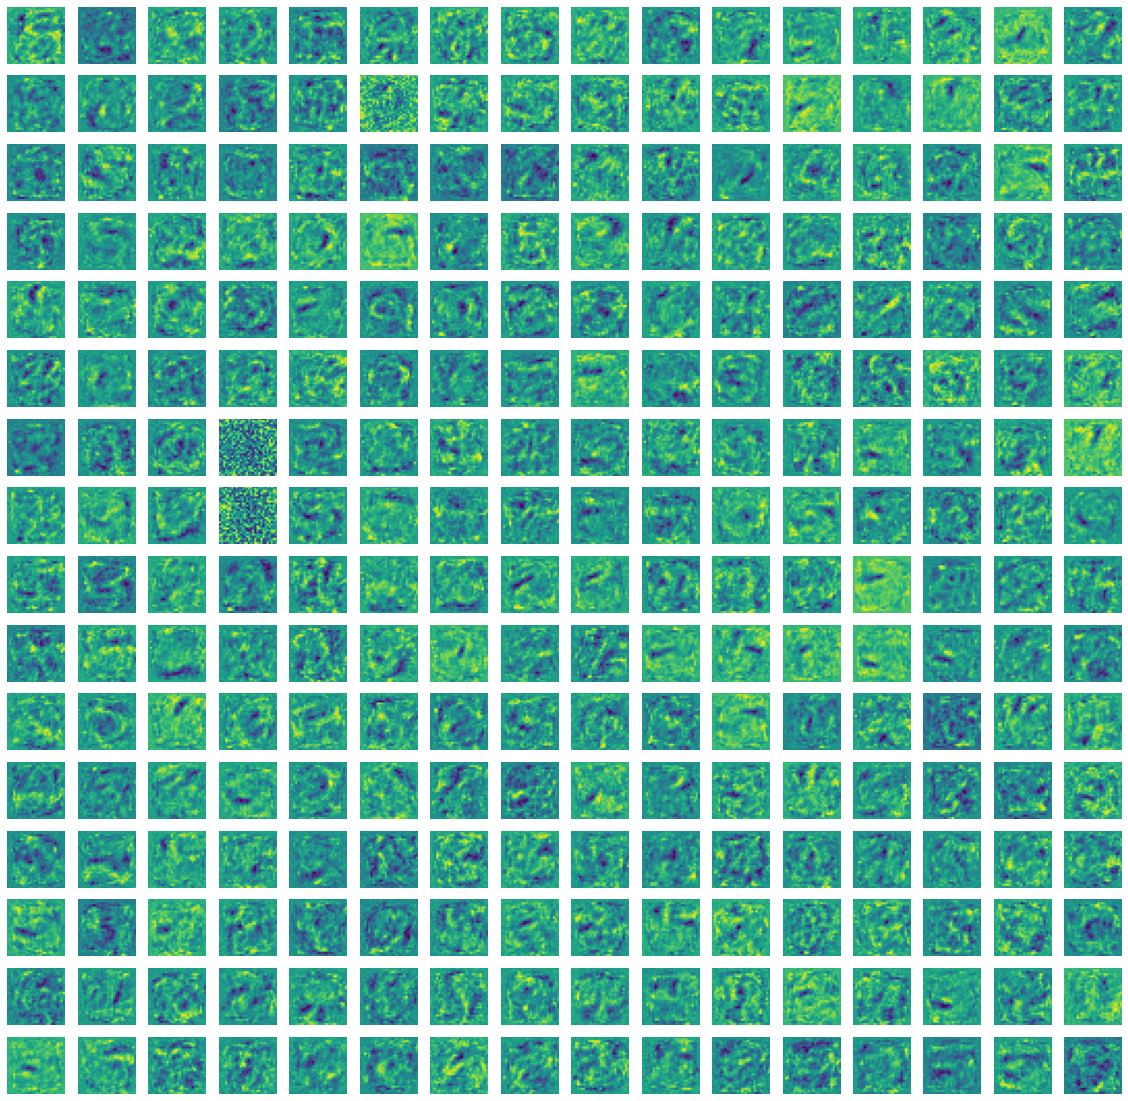

In [35]:
visualise_hidden_neurons(model, 1, n_hidden_neurons, (28, 28))

In [36]:
dim = int(np.sqrt(n_hidden_neurons))

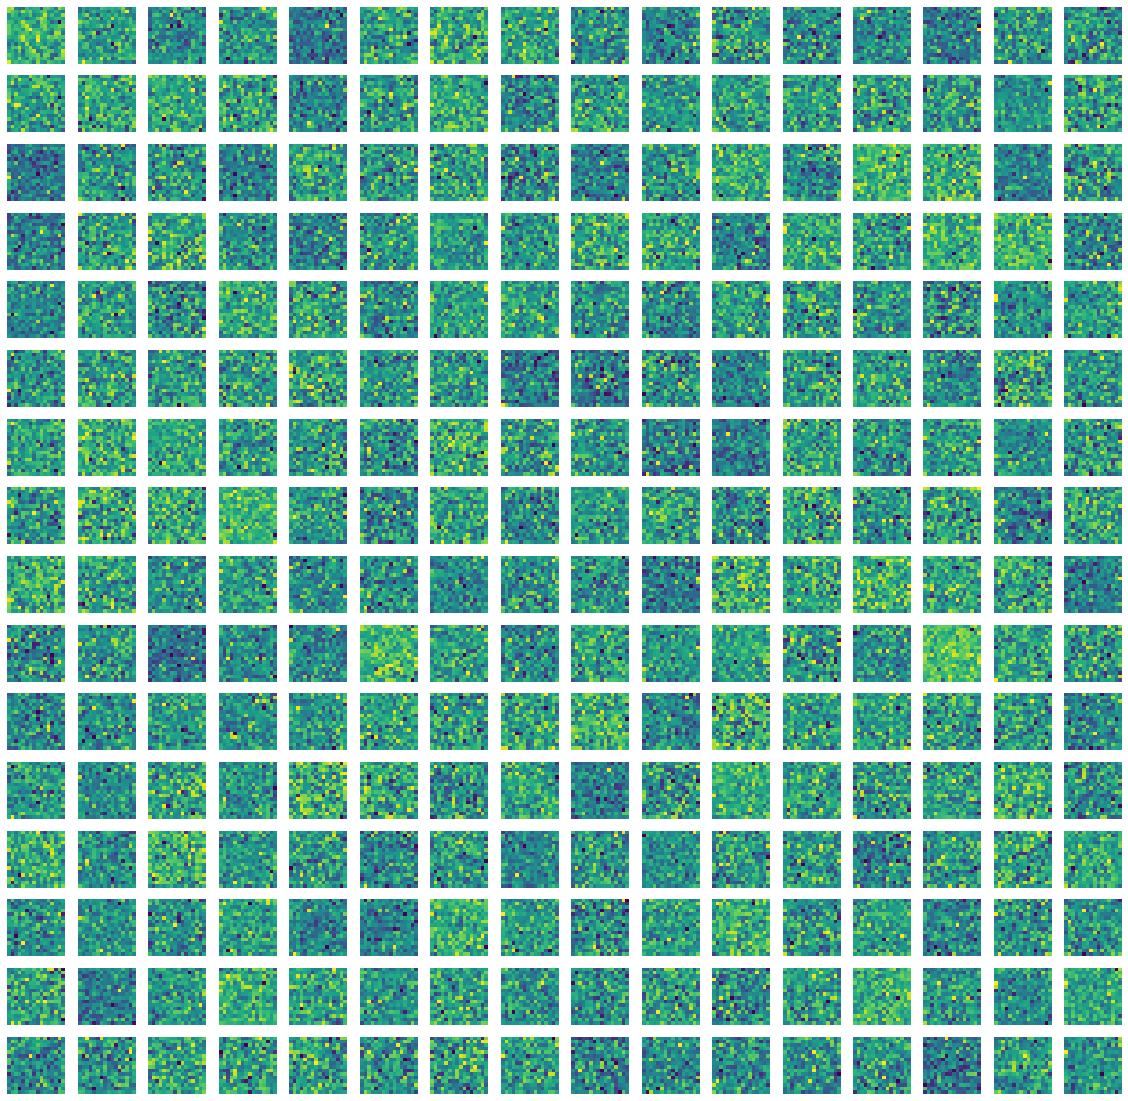

In [37]:
visualise_hidden_neurons(model, 2, n_hidden_neurons, (dim, dim))

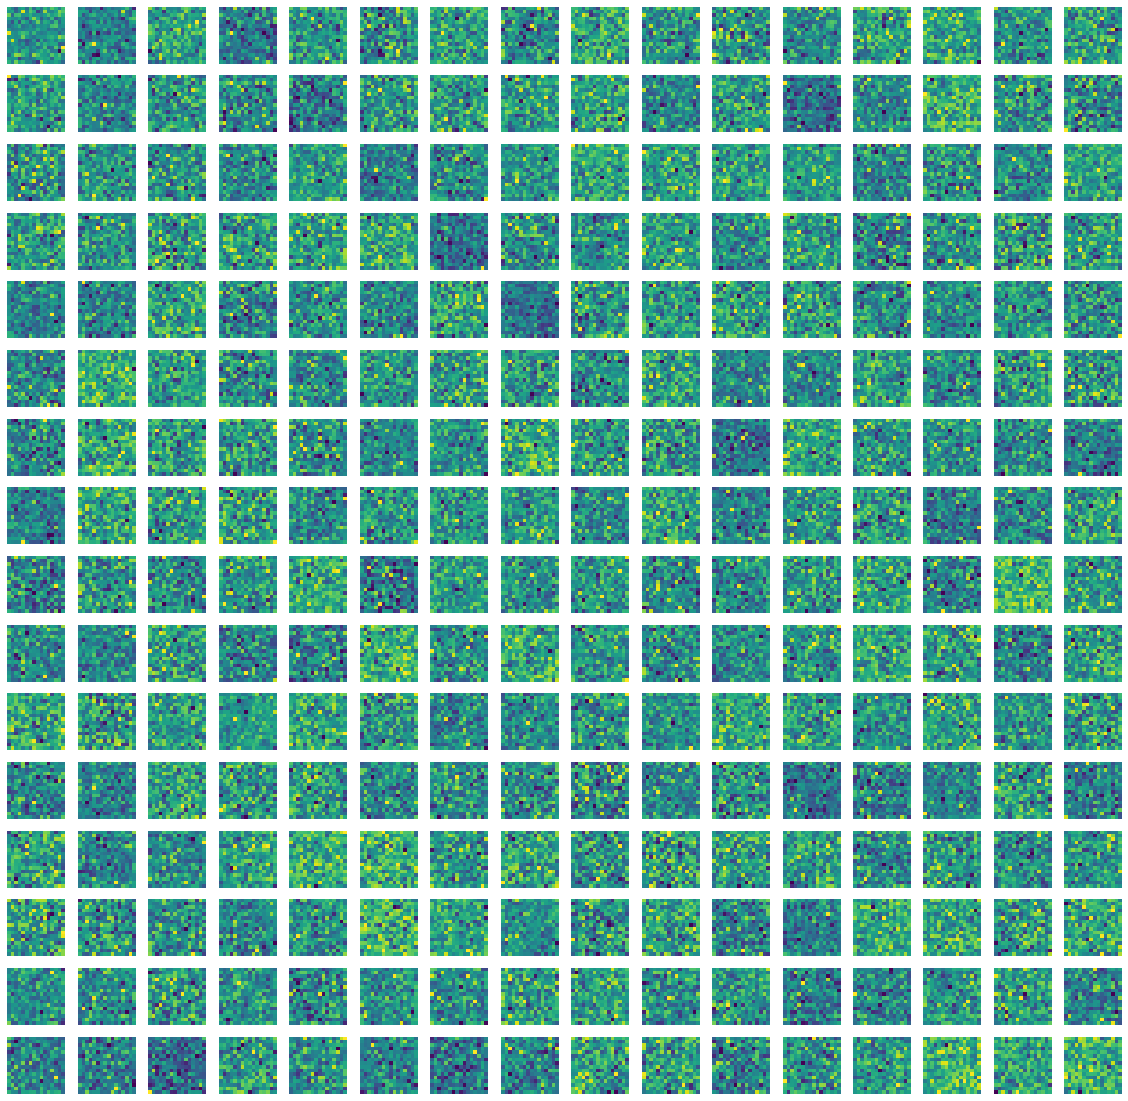

In [38]:
visualise_hidden_neurons(model, 3, n_hidden_neurons, (dim, dim))

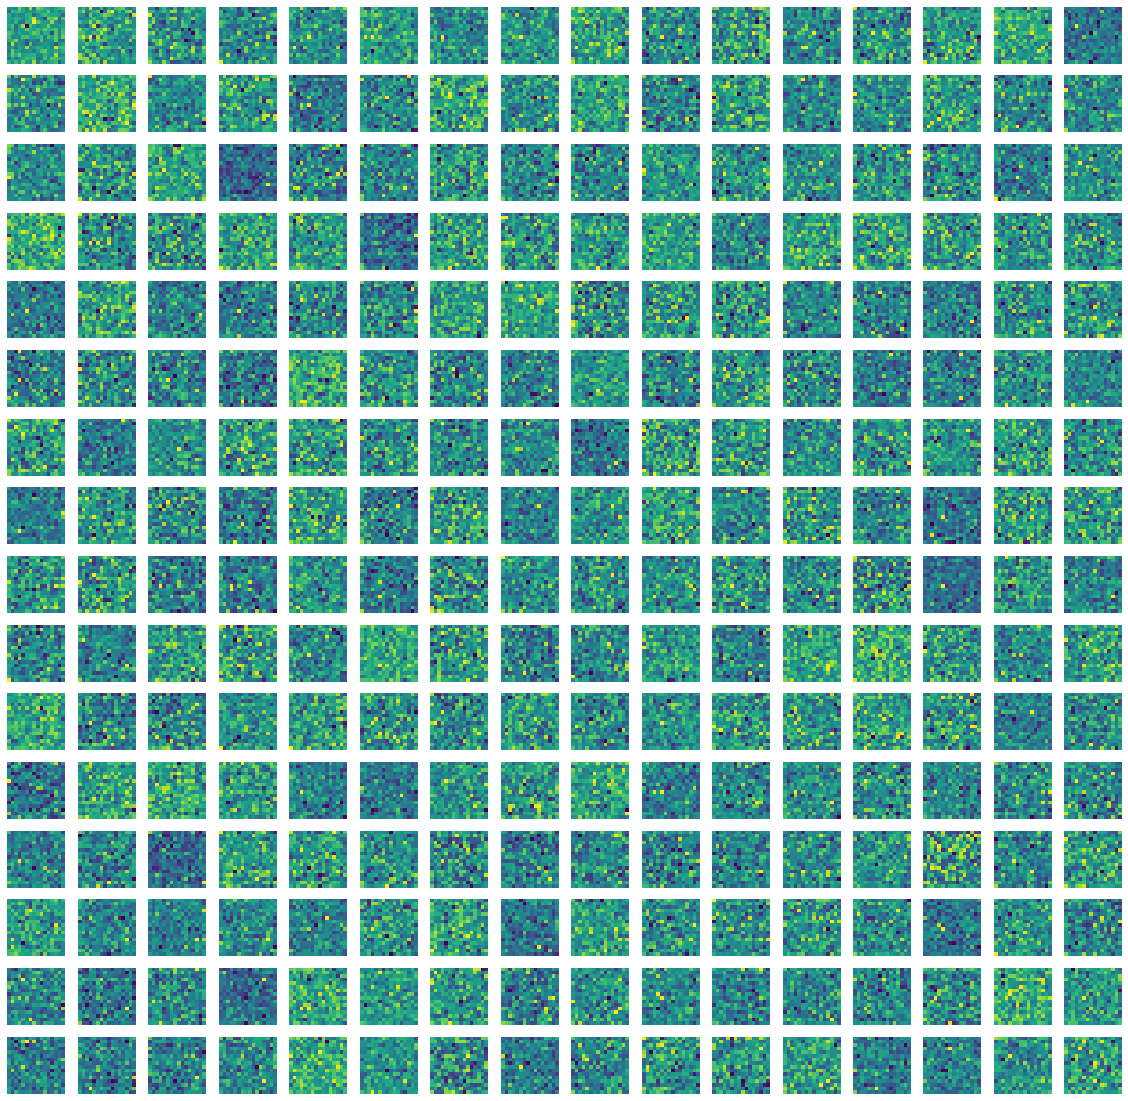

In [39]:
visualise_hidden_neurons(model, 4, n_hidden_neurons, (dim, dim))

# Clusterability analysis

In [40]:
import sys

from sklearn.utils import shuffle

sys.path.insert(0, '../clusterability_in_neural_networks/')
from src import spectral_cluster_model, train_nn

/Users/dwright/anaconda2/envs/polysemantic_neurons/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.kde module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
Using TensorFlow backend.


In [41]:
i_save = tf.keras.layers.Input(shape=(28*28,))
e1_save = tf.keras.layers.Dense(n_hidden_neurons, activation='relu', name='dense_1')(i_save)
e2_save = tf.keras.layers.Dense(n_hidden_neurons, activation='relu', name='dense_2')(e1_save)
e3_save = tf.keras.layers.Dense(n_hidden_neurons, activation='relu', name='dense_3')(e2_save)
e4_save = tf.keras.layers.Dense(n_hidden_neurons, activation='relu', name='dense_4')(e3_save)
o_save = tf.keras.layers.Dense(10, activation='softmax', name='softmax')(e4_save)
model_save = tf.keras.Model(inputs=i_save, outputs=o_save)
for i,layer in enumerate(model.layers[:5]):
    print(layer)
    model_save.layers[i].set_weights(layer.get_weights())
# model_save.save_weights('./mnist_penalise_polysemantic_neurons_all_classes_clusterability_weights.h5')
model_save.save_weights('./mnist_penalise_polysemantic_neurons_all_classes_clusterability_weights_loss_test.h5')
model_save.load_weights('./mnist_penalise_polysemantic_neurons_all_classes_clusterability_weights_loss_test.h5')

https://github.com/dfilan/clusterability_in_neural_networks/blob/72602084ea8d686a80fb7e7ec4d736846f83b27f/src/spectral_cluster_model.py#L40

In [42]:
weights = [w for w in model_save.get_weights() if len(w.shape)==2] # skip biases
print(weights[-1].shape)
adj_mat = spectral_cluster_model.weights_to_graph(weights)

(256, 10)


In [43]:
clustering_labels = spectral_cluster_model.cluster_net(12, adj_mat, 'arpack', assign_labels='kmeans')

In [44]:
n_cut = spectral_cluster_model.compute_ncut(adj_mat, clustering_labels, epsilon=1e-8, verbose=True)
print(type(n_cut))
print('n-cut :', n_cut)

ncut term 0 5003.582087207559 5755.173477180683
ncut term 1 3113.4594149031736 3480.4815263264873
ncut term 2 5631.12015638897 7492.357556904841
ncut term 3 3605.143190464276 4050.2934684186857
ncut term 4 12975.706438220857 18866.845479170537
ncut term 5 4651.583431115283 5391.652282394611
ncut term 6 11264.190416631372 14869.477511424364
ncut term 7 3296.353073361504 3707.7166866436014
ncut term 8 7547.363936936665 9175.923511516878
ncut term 9 6411.441686469763 7619.266298282637
ncut term 10 8666.025452002508 12227.241462774058
ncut term 11 193.26180178672075 193.26180178672075
<class 'numpy.float64'>
n-cut : 9.97545332996439


In [45]:
shuffled_n_cuts = []
for j in range(50):
    shuffled_weights = shuffled_weights = [spectral_cluster_model.shuffle_weights(w) for w in weights[:]]
    shuffled_adj_mat = spectral_cluster_model.weights_to_graph(shuffled_weights)
    shuffled_clustering_labels = spectral_cluster_model.cluster_net(12, shuffled_adj_mat, 'arpack', assign_labels='kmeans')
    shuffled_n_cut = spectral_cluster_model.compute_ncut(shuffled_adj_mat, shuffled_clustering_labels, epsilon=1e-8, verbose=True)
    print(shuffled_n_cut)
    shuffled_n_cuts.append(shuffled_n_cut)

ncut term 0 5322.548842536637 6027.672665356282
ncut term 1 6793.670221786624 9264.546837176973
ncut term 2 6825.326253356499 7936.656474117188
ncut term 3 5065.7008713885725 5713.989597150284
ncut term 4 3781.6004848201596 4156.917065209924
ncut term 5 5733.538019443328 6568.9744483132645
ncut term 6 15486.778760927096 29442.73077666817
ncut term 7 5260.997952487229 5968.566023754416
ncut term 8 5408.733739206225 6165.6764552821915
ncut term 9 193.26180178672075 193.26180178672075
ncut term 10 5265.757730493002 5972.126945182652
ncut term 11 4829.086971083243 5418.571972826039
10.20298177571101
ncut term 0 5349.324374661982 6090.3962771328925
ncut term 1 4838.08915632529 5430.839278820926
ncut term 2 15456.23828320789 30405.79324513906
ncut term 3 6738.730890706371 8288.972130822698
ncut term 4 5534.210495320516 6303.578293034496
ncut term 5 5535.594933422461 6280.752480323015
ncut term 6 5233.750678136061 5951.177993683388
ncut term 7 193.26180178672075 193.26180178672075
ncut term 8

ncut term 0 4648.0509227318835 5226.36160351758
ncut term 1 6792.996051589735 9530.480982860829
ncut term 2 5548.199831848441 6307.164225204703
ncut term 3 4805.942415350448 5390.624099901539
ncut term 4 5769.045848130819 6593.29369021398
ncut term 5 193.26180178672075 193.26180178672075
ncut term 6 5006.27499737136 5634.963429228106
ncut term 7 15439.791178405269 28983.16448946784
ncut term 8 6269.861977536077 7270.7484459999305
ncut term 9 5166.638685483597 5809.912187864388
ncut term 10 5814.393814442449 6648.235687135103
ncut term 11 4729.244631351531 5241.48041964339
10.197920136106298
ncut term 0 5458.400823642449 6186.963259917691
ncut term 1 6123.058998481304 7034.866879945729
ncut term 2 15387.76395501151 29228.968998648772
ncut term 3 5437.18913887768 6178.04984491526
ncut term 4 6010.509145476288 6937.4199187269605
ncut term 5 6774.9761796684925 9143.669419692047
ncut term 6 4534.440534378345 5076.941405270657
ncut term 7 4774.183630283604 5350.702780256885
ncut term 8 193.2

ncut term 0 5619.527238245948 6373.732284552305
ncut term 1 4978.36013777713 5610.460000590028
ncut term 2 15590.930856779387 28182.257412376595
ncut term 3 193.26180178672075 193.26180178672075
ncut term 4 5096.410257856686 5746.60569885196
ncut term 5 6922.418463078515 10458.27372511488
ncut term 6 6479.364796297833 7497.240726732546
ncut term 7 5262.900989181643 5946.297817010684
ncut term 8 5250.318979186879 5935.133046424948
ncut term 9 5546.054383494187 6317.201173654359
ncut term 10 4722.218963612327 5291.599182160328
ncut term 11 4725.293909042447 5277.62819356875
10.170581805154958
ncut term 0 6242.6773712116665 7227.658767358076
ncut term 1 6021.376543003231 6896.230838460522
ncut term 2 15435.49281694544 29122.3781559242
ncut term 3 5269.8798041222635 5930.249752044345
ncut term 4 4783.373096930759 5358.218713449221
ncut term 5 5531.171098723964 6292.6117013101975
ncut term 6 5276.093853028331 5978.410716317714
ncut term 7 4852.8727424867275 5468.128211461549
ncut term 8 442

ncut term 0 4990.100684831571 5623.55011820969
ncut term 1 15559.513785896179 28732.246684976744
ncut term 2 5785.424078146343 6643.523243498621
ncut term 3 5158.624144549962 5851.603262084289
ncut term 4 5526.513271418682 6265.468884606666
ncut term 5 4870.52304602759 5473.874370756265
ncut term 6 6866.131528562533 9975.030928868397
ncut term 7 4568.637011493765 5096.537433219904
ncut term 8 193.26180178672075 193.26180178672075
ncut term 9 5224.5837773926405 5916.942560379673
ncut term 10 6141.098060912103 7071.234115968822
ncut term 11 5259.682403361361 5986.41765846831
10.167942377849707
ncut term 0 4615.654022467095 5119.617602523684
ncut term 1 6931.168084102275 10268.792228617818
ncut term 2 5546.74432496306 6309.851185711974
ncut term 3 15601.433490219193 28371.54531237589
ncut term 4 193.26180178672075 193.26180178672075
ncut term 5 5282.425226411932 6013.76191532915
ncut term 6 5429.28488202597 6176.383348918609
ncut term 7 5704.871461080702 6550.976943768381
ncut term 8 5233

In [46]:
shuffled_n_cuts

[10.20298177571101,
 10.264435849888544,
 10.218855271669531,
 10.210516488280295,
 10.17245552238916,
 10.158848379457298,
 10.180399664891416,
 10.221157868665392,
 10.236953470724034,
 10.212045725136239,
 10.210101711957593,
 10.181005242792127,
 10.172874833401014,
 10.20560692608793,
 10.197920136106298,
 10.20804830084019,
 10.19788213942454,
 10.216989314035875,
 10.182197478408158,
 10.217104200794644,
 10.155767225066107,
 10.19835687687682,
 10.23729221065946,
 10.207692521006239,
 10.225062927256062,
 10.218148665168426,
 10.239777698439957,
 10.200394375441892,
 10.170581805154958,
 10.209104132459473,
 10.225587322239504,
 10.171469638135902,
 10.19332878702696,
 10.226653813960473,
 10.23405148472317,
 10.221019363816174,
 10.211198120257878,
 10.215098467013572,
 10.192565022215438,
 10.206802811973041,
 10.205691684366725,
 10.230376615366506,
 10.167942377849707,
 10.162280438631988,
 10.187472658691547,
 10.185175598999557,
 10.188730207482994,
 10.177639069382337,
 

In [47]:
np.mean(shuffled_n_cuts)

10.20229673113336

In [48]:
np.std(shuffled_n_cuts)

0.02329098814867664

In [49]:
z_score = (n_cut - np.mean(shuffled_n_cuts)) / np.std(shuffled_n_cuts)

In [50]:
z_score

-9.73953529669627